0) IMPORT ทุกอย่างที่ต้องใช้

In [1]:
import os
import time
import copy

import numpy as np
import pandas as pd
import cv2
from PIL import Image

import kagglehub   # ใช้โหลด dataset จาก Kaggle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

# ใช้ GPU ถ้ามี ไม่มีก็ใช้ CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


2. Load Dataset (Kaggle BUSI)

In [2]:
import kagglehub

# โหลด dataset
dpath = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
print("Dataset path:", dpath)

folder = os.path.join(dpath, "Dataset_BUSI_with_GT")
print("Classes:", os.listdir(folder))

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Dataset path: /kaggle/input/breast-ultrasound-images-dataset
Classes: ['benign', 'normal', 'malignant']


3. Build DataFrame

In [3]:
class_names = ["benign", "malignant", "normal"]
data = []

for idx, cls in enumerate(class_names):
    cdir = os.path.join(folder, cls)
    for fname in os.listdir(cdir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            data.append([os.path.join(cdir, fname), idx])

df = pd.DataFrame(data, columns=["path","label"])
print("Total images:", len(df))


Total images: 1578


4. Train/Val/Test split

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1765, stratify=train_df["label"], random_state=42)

print(len(train_df), len(val_df), len(test_df))

1104 237 237


5. Dataset Class + CLAHE + Augmentation

In [5]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.Normalize([0.485]*3, [0.229]*3),
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3),
])


class BUSIDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = clahe.apply(img)
        img = cv2.resize(img, (224,224))

        img = np.stack([img, img, img], axis=-1)
        img = img.astype("uint8")

        img = transforms.ToPILImage()(img)
        img = self.transform(img)

        return {"image": img, "label": torch.tensor(label).long()}

6. DataLoader

In [6]:
# 6. DataLoader + WeightedRandomSampler

from torch.utils.data import WeightedRandomSampler

train_ds = BUSIDataset(train_df, train_tf)
val_ds   = BUSIDataset(val_df,   val_tf)
test_ds  = BUSIDataset(test_df,  val_tf)

# ---- นับจำนวนตัวอย่างแต่ละคลาสใน train_df ----
class_counts = train_df["label"].value_counts().sort_index().to_numpy()

# base weights = inverse frequency
class_weights = 1.0 / class_counts

# ⭐ เพิ่มน้ำหนักให้ malignant (class 1) เพื่อดัน recall
class_weights[1] *= 1.3   # ลอง 2.0 ก่อน ถ้าอยากแรงขึ้นค่อยขยับ 2.5 / 3.0 ได้

print("Class counts:", class_counts)
print("Class weights:", class_weights)

# แปลง label ของแต่ละตัวอย่าง -> weight
sample_weights = train_df["label"].map(lambda y: class_weights[y]).to_numpy()

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

# ❗ เมื่อใช้ sampler ไม่ต้อง shuffle แล้ว
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_ds), "val": len(val_ds)}


Class counts: [623 295 186]
Class weights: [0.00160514 0.00440678 0.00537634]


7. Focal Loss

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce = nn.CrossEntropyLoss(reduction="none")(logits, targets)
        pt = torch.exp(-ce)
        focal = ((1 - pt)**self.gamma) * ce

        if self.alpha is not None:
            alpha_t = self.alpha.to(logits.device)[targets]
            focal = alpha_t * focal

        return focal.mean() if self.reduction=="mean" else focal.sum()

In [8]:
# compute class weight
labels_np = train_df["label"].values
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_np),
    y=labels_np
)

# boost malignant a bit
class_weights_np[1] *= 1.5

alpha_tensor = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
criterion = FocalLoss(alpha=alpha_tensor, gamma=1.5)
print("Focal alpha:", alpha_tensor)

Focal alpha: tensor([0.5907, 1.8712, 1.9785])


8. Hybrid CNN + Transformer Model

In [9]:
class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes=3, backbone="resnet18",
                 num_layers=2, nhead=8, dim_feedforward=1024, dropout=0.1):
        super().__init__()

        if backbone=="resnet18":
            resnet = models.resnet18(pretrained=True)
            fdim = 512
        else:
            resnet = models.resnet50(pretrained=True)
            fdim = 2048

        self.conv1 = resnet.conv1
        self.bn1   = resnet.bn1
        self.relu  = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.fdim = fdim
        self.cls_token = nn.Parameter(torch.randn(1,1,fdim))
        self.pos_embed = nn.Parameter(torch.randn(1,50,fdim))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=fdim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(fdim),
            nn.Linear(fdim, fdim//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fdim//2, num_classes)
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x); x=self.layer2(x); x=self.layer3(x); x=self.layer4(x)

        B,C,H,W = x.shape
        x = x.view(B, C, H*W).transpose(1,2)

        cls = self.cls_token.expand(B,-1,-1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed[:,:x.size(1)]

        x = self.transformer(x)
        return self.head(x[:,0])

In [10]:
model_hybrid = CNNTransformerHybrid(
    num_classes=3,
    backbone="resnet18"
).to(device)

print(model_hybrid)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


CNNTransformerHybrid(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

9. Two-Phase Fine-Tuning

In [11]:
# -------- CutMix Helpers --------
def rand_bbox(size, lam):
    W = size[3]; H = size[2]
    cut_rat = np.sqrt(1-lam)
    cut_w = int(W*cut_rat)
    cut_h = int(H*cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx-cut_w//2, 0, W)
    x2 = np.clip(cx+cut_w//2, 0, W)
    y1 = np.clip(cy-cut_h//2, 0, H)
    y2 = np.clip(cy+cut_h//2, 0, H)

    return x1, y1, x2, y2

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)

    y_a = y
    y_b = y[rand_index]

    x1, y1, x2, y2 = rand_bbox(x.size(), lam)
    x[:, :, y1:y2, x1:x2] = x[rand_index, :, y1:y2, x1:x2]

    lam = 1 - ((x2-x1)*(y2-y1)/(x.size(-1)*x.size(-2)))
    return x, y_a, y_b, lam


# -------- Updated Train Function --------
def train_model(model, criterion, optimizer, dataloaders, sizes,
                num_epochs=10, scheduler=None, phase_name="Phase"):

    best_w = None
    best_loss = 1e9

    for epoch in range(num_epochs):
        print(f"\n{phase_name} Epoch {epoch+1}/{num_epochs}")

        for phase in ["train","val"]:
            model.train() if phase=="train" else model.eval()

            running_loss = 0
            running_corrects = 0.0

            for batch in dataloaders[phase]:
                imgs = batch["image"].to(device)
                labels = batch["label"].to(device)

                optimizer.zero_grad()

                # ---- CutMix (train only) ----
                use_cutmix = False
                if phase=="train" and labels.eq(1).any() and np.random.rand()<0.6:
                  use_cutmix = True

                if use_cutmix:
                    imgs, y_a, y_b, lam = cutmix_data(imgs, labels)
                    outputs = model(imgs)
                    loss = lam*criterion(outputs, y_a) + (1-lam)*criterion(outputs, y_b)
                else:
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)

                preds = outputs.argmax(1)

                if phase=="train":
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

                running_loss += loss.item()*imgs.size(0)

                if use_cutmix:
                    running_corrects += lam*(preds==y_a).sum() + (1-lam)*(preds==y_b).sum()
                else:
                    running_corrects += (preds==labels).sum()

            ep_loss = running_loss / sizes[phase]
            ep_acc  = running_corrects.double() / sizes[phase]

            print(f"{phase}: loss={ep_loss:.4f} acc={ep_acc:.4f}")

            if phase == "val":
                if ep_loss < best_loss:
                    best_loss = ep_loss
                    best_w = model.state_dict()

                if scheduler:
                    scheduler.step(ep_loss)

    model.load_state_dict(best_w)
    return model

In [12]:
# Phase 1: Freeze CNN backbone
for name, param in model_hybrid.named_parameters():
    if name.startswith(("conv1","bn1","layer1","layer2","layer3","layer4")):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer1 = optim.AdamW(
    filter(lambda p: p.requires_grad, model_hybrid.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

model_hybrid = train_model(
    model_hybrid, criterion, optimizer1,
    dataloaders, dataset_sizes,
    num_epochs=8,
    phase_name="Hybrid Phase 1"
)


Hybrid Phase 1 Epoch 1/8
train: loss=0.6746 acc=0.5138
val: loss=0.7202 acc=0.3038

Hybrid Phase 1 Epoch 2/8
train: loss=0.5981 acc=0.5986
val: loss=0.3757 acc=0.6624

Hybrid Phase 1 Epoch 3/8
train: loss=0.5110 acc=0.6753
val: loss=0.3376 acc=0.6582

Hybrid Phase 1 Epoch 4/8
train: loss=0.5518 acc=0.6372
val: loss=0.3777 acc=0.5949

Hybrid Phase 1 Epoch 5/8
train: loss=0.4550 acc=0.7017
val: loss=0.2950 acc=0.7553

Hybrid Phase 1 Epoch 6/8
train: loss=0.5173 acc=0.6758
val: loss=0.2796 acc=0.7426

Hybrid Phase 1 Epoch 7/8
train: loss=0.4956 acc=0.6907
val: loss=0.3077 acc=0.7468

Hybrid Phase 1 Epoch 8/8
train: loss=0.4676 acc=0.6976
val: loss=0.2709 acc=0.7679


Phase 2: Unfreeze layer4 + Transformer + Head

In [13]:
for name, param in model_hybrid.named_parameters():
    if name.startswith(("layer3","layer4","transformer","head","cls_token","pos_embed")):
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer2 = optim.AdamW(
    filter(lambda p: p.requires_grad, model_hybrid.parameters()),
    lr=2e-4,
    weight_decay=1e-4
)

scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2, mode="min", factor=0.5, patience=2
)

model_hybrid = train_model(
    model_hybrid, criterion, optimizer2,
    dataloaders, dataset_sizes,
    num_epochs=12,
    scheduler=scheduler2,
    phase_name="Hybrid Phase 2"
)

best_model_hybrid = model_hybrid


Hybrid Phase 2 Epoch 1/12
train: loss=0.4992 acc=0.6972
val: loss=0.2970 acc=0.7384

Hybrid Phase 2 Epoch 2/12
train: loss=0.4384 acc=0.7185
val: loss=0.2948 acc=0.6878

Hybrid Phase 2 Epoch 3/12
train: loss=0.3996 acc=0.7567
val: loss=0.2858 acc=0.7595

Hybrid Phase 2 Epoch 4/12
train: loss=0.3684 acc=0.7721
val: loss=0.4685 acc=0.7637

Hybrid Phase 2 Epoch 5/12
train: loss=0.4167 acc=0.7411
val: loss=0.2574 acc=0.7595

Hybrid Phase 2 Epoch 6/12
train: loss=0.3785 acc=0.7807
val: loss=0.2192 acc=0.8354

Hybrid Phase 2 Epoch 7/12
train: loss=0.4205 acc=0.7430
val: loss=0.2335 acc=0.8354

Hybrid Phase 2 Epoch 8/12
train: loss=0.3426 acc=0.8016
val: loss=0.1927 acc=0.8692

Hybrid Phase 2 Epoch 9/12
train: loss=0.2829 acc=0.8388
val: loss=0.2440 acc=0.8143

Hybrid Phase 2 Epoch 10/12
train: loss=0.4132 acc=0.7503
val: loss=0.2958 acc=0.7342

Hybrid Phase 2 Epoch 11/12
train: loss=0.3605 acc=0.8052
val: loss=0.2766 acc=0.8017

Hybrid Phase 2 Epoch 12/12
train: loss=0.3134 acc=0.8126
val: 

10. Evaluate on Test Set

In [14]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
best_model_hybrid.eval()
probs=[]
labels=[]

with torch.no_grad():
    for batch in test_loader:
        x=batch["image"].to(device)
        y=batch["label"].to(device)
        o=best_model_hybrid(x)
        p=torch.softmax(o,1)

        probs.append(p.cpu().numpy())
        labels.append(y.cpu().numpy())

y_pred_proba=np.concatenate(probs)
y_test=np.concatenate(labels)
y_pred=np.argmax(y_pred_proba,1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Macro Recall:", recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8565400843881856
Macro F1: 0.8564553215094829
Macro Recall: 0.8805871436468452
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       134
           1       0.69      0.97      0.80        63
           2       0.90      0.88      0.89        40

    accuracy                           0.86       237
   macro avg       0.85      0.88      0.86       237
weighted avg       0.89      0.86      0.86       237

[[107  23   4]
 [  2  61   0]
 [  0   5  35]]


Confusion Matrix:
 [[107  23   4]
 [  2  61   0]
 [  0   5  35]]


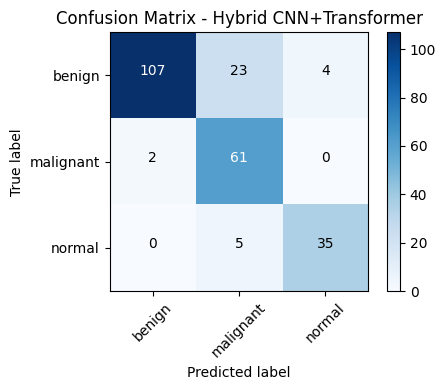

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Hybrid CNN+Transformer")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

11. Threshold tuning

In [16]:
def eval_threshold(y_pred_proba, y_true, th):
    yp=[]
    for p in y_pred_proba:
        if p[1] >= th:
            yp.append(1)
        else:
            yp.append(0 if p[0]>=p[2] else 2)

    print("\n=== T =",th,"===")
    print("Acc:", accuracy_score(y_true, yp))
    print("Macro F1:", f1_score(y_true, yp, average="macro"))
    print("Macro Recall:", recall_score(y_true, yp, average="macro"))
    print(confusion_matrix(y_true, yp))

for th in [0.30,0.35,0.40,0.45,0.50]:
    eval_threshold(y_pred_proba, y_test, th)


=== T = 0.3 ===
Acc: 0.7848101265822784
Macro F1: 0.8018203640594238
Macro Recall: 0.8380597014925373
[[89 42  3]
 [ 0 63  0]
 [ 0  6 34]]

=== T = 0.35 ===
Acc: 0.8270042194092827
Macro F1: 0.8337316579230114
Macro Recall: 0.8629353233830845
[[99 32  3]
 [ 0 63  0]
 [ 0  6 34]]

=== T = 0.4 ===
Acc: 0.8565400843881856
Macro F1: 0.8563326623836178
Macro Recall: 0.8803482587064676
[[106  25   3]
 [  0  63   0]
 [  0   6  34]]

=== T = 0.45 ===
Acc: 0.8523206751054853
Macro F1: 0.8557498339633417
Macro Recall: 0.8780995814577904
[[106  25   3]
 [  2  61   0]
 [  1   4  35]]

=== T = 0.5 ===
Acc: 0.869198312236287
Macro F1: 0.8670295109335749
Macro Recall: 0.8880498302140093
[[110  20   4]
 [  2  61   0]
 [  1   4  35]]


Grad-CAM

In [17]:
import matplotlib.pyplot as plt

# transform แบบไม่มี augmentation ใช้สำหรับ Grad-CAM
cam_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3),
])
IMG_SIZE = 224

In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: โมเดล PyTorch
        target_layer: เลเยอร์ convolution ที่อยากดู เช่น model.layer4
        """
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # forward hook: เก็บ feature map
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # backward hook: เก็บ gradient ของ feature map
        def backward_hook(module, grad_in, grad_out):
            # grad_out[0] คือ gradient w.r.t. output
            self.gradients = grad_out[0].detach()

        self.fh = self.target_layer.register_forward_hook(forward_hook)
        self.bh = self.target_layer.register_backward_hook(backward_hook)

    def generate(self, x, class_idx=None):
        """
        x: tensor (1,3,H,W)
        class_idx: index ของคลาสที่อยากทำ Grad-CAM (0/1/2)
                   ถ้า None จะใช้ predicted class
        return: heatmap (numpy 2D, ขนาด HxW, normalized 0-1)
        """
        self.model.eval()
        self.model.zero_grad()

        x = x.to(device)
        scores = self.model(x)  # (1, num_classes)

        if class_idx is None:
            class_idx = scores.argmax(dim=1).item()

        target = scores[0, class_idx]
        target.backward()

        # activations: (B,C,H,W)
        # gradients:   (B,C,H,W)
        acts = self.activations[0]   # (C,H,W)
        grads = self.gradients[0]    # (C,H,W)

        # global average pooling บน gradient
        weights = grads.mean(dim=(1,2))   # (C,)

        # weighted sum ของ feature map
        cam = torch.zeros_like(acts[0])
        for w, a in zip(weights, acts):
            cam += w * a

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy()  # (H,W)

    def close(self):
        self.fh.remove()
        self.bh.remove()

In [19]:
gradcam = GradCAM(best_model_hybrid, best_model_hybrid.layer4)

In [20]:
import cv2

def show_gradcam_on_image(img_path, true_label=None, class_idx=None):
    """
    img_path: path รูปใน test set
    true_label: label จริง (0/1/2) ไว้โชว์เฉย ๆ
    class_idx: class ที่จะทำ Grad-CAM (ถ้า None = predicted class)
    """
    # ----- โหลดภาพต้นฉบับแบบ grayscale -----
    orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    h0, w0 = orig.shape[:2]

    # ทำ CLAHE ให้เหมือนตอนเทรน
    img_clahe = clahe.apply(orig)
    img_resized = cv2.resize(img_clahe, (IMG_SIZE, IMG_SIZE))

    # ทำเป็น 3-channel
    img_3ch = np.stack([img_resized]*3, axis=-1).astype("uint8")

    # แปลงเป็น tensor และ normalize
    pil_img = transforms.ToPILImage()(img_3ch)
    x = cam_tf(pil_img).unsqueeze(0)  # (1,3,224,224)

    # ----- ทำ Grad-CAM -----
    cam = gradcam.generate(x, class_idx=class_idx)  # (Hc,Wc) เช่น 7x7 -> ถูก upsample ในขั้นต่อไป

    # resize CAM ให้เท่ากับภาพต้นฉบับ
    cam_resized = cv2.resize(cam, (w0, h0))

    # ทำเป็น heatmap สี
    heatmap = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # รวม heatmap กับภาพ grayscale เดิม (ต้องแปลงเป็น BGR 3 ช่อง)
    orig_bgr = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(orig_bgr, 0.5, heatmap, 0.5, 0)

    # แปลงเป็น RGB สำหรับ matplotlib
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # ----- ทำนาย class ด้วยโมเดล -----
    best_model_hybrid.eval()
    with torch.no_grad():
        logits = best_model_hybrid(x.to(device))
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_class = np.argmax(probs)

    # ----- แสดงผล -----
    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(orig_rgb, cmap="gray")
    plt.axis("off")
    plt.title(f"Original\nlabel={true_label}")

    plt.subplot(1,3,2)
    plt.imshow(cam_resized, cmap="jet")
    plt.axis("off")
    plt.title("Grad-CAM (mask)")

    plt.subplot(1,3,3)
    plt.imshow(overlay_rgb)
    plt.axis("off")
    plt.title(f"Overlay\npred={pred_class}, probs={probs.round(2)}")

    plt.tight_layout()
    plt.show()

Path: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (83)_mask.png Label: 1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


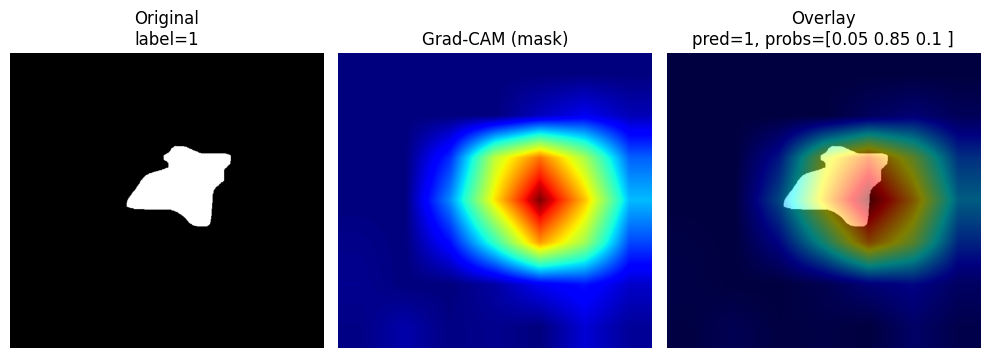

In [21]:
# เลือก index ของ malignant จาก test_df
mal_idx = test_df[test_df["label"] == 1].index[0]
mal_path = test_df.loc[mal_idx, "path"]
mal_label = test_df.loc[mal_idx, "label"]

print("Path:", mal_path, "Label:", mal_label)  # label=1 คือ malignant

show_gradcam_on_image(mal_path, true_label=mal_label)


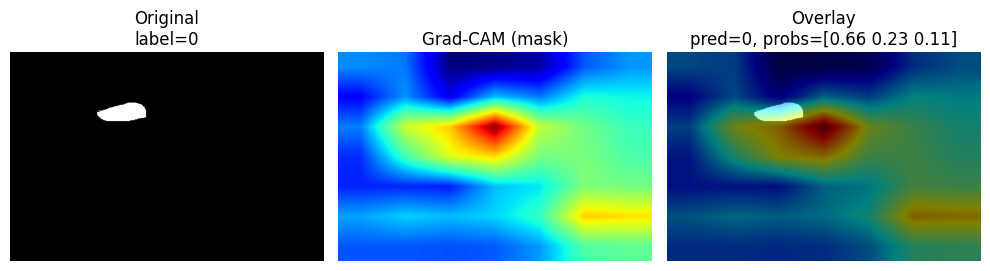

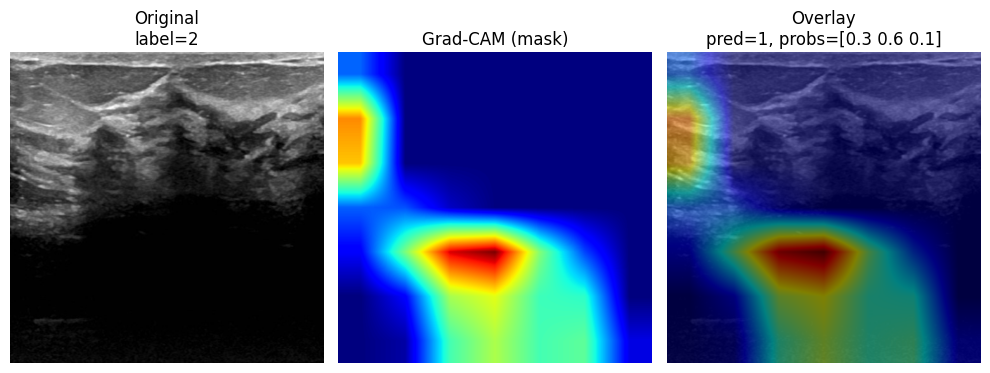

In [22]:
# benign
ben_idx = test_df[test_df["label"] == 0].index[0]
ben_path = test_df.loc[ben_idx, "path"]
ben_label = test_df.loc[ben_idx, "label"]
show_gradcam_on_image(ben_path, true_label=ben_label)

# normal
nor_idx = test_df[test_df["label"] == 2].index[0]
nor_path = test_df.loc[nor_idx, "path"]
nor_label = test_df.loc[nor_idx, "label"]
show_gradcam_on_image(nor_path, true_label=nor_label)
